<a href="https://colab.research.google.com/github/ayanoglu/OrtalamaTahmin/blob/NewData/REDGPAmainNEWDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from numpy import array
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
np.set_printoptions(linewidth=160)
import tensorflow as tf
import csv
import math
import matplotlib.pyplot as plt
from decimal import *
from google.colab import files
import plotly.graph_objects as go
import plotly.express as px
import itertools
from itertools import combinations
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from google.colab import files
import io
uploaded = files.upload()

Saving EE Students Spring 2021.csv to EE Students Spring 2021.csv
Saving Engineering Freshmen Fall 21 - January 31 22.csv to Engineering Freshmen Fall 21 - January 31 22.csv
Saving Engineering Freshmen Spring 2021.csv to Engineering Freshmen Spring 2021.csv
Saving Psychology Subject Pool May 2021 - Jan 31 2022.csv to Psychology Subject Pool May 2021 - Jan 31 2022.csv
Saving Psychology Subject Pool Spring 2021.csv to Psychology Subject Pool Spring 2021.csv


In [2]:
DF_EEStudentsSpring2021 = pd.read_csv(io.BytesIO(uploaded['EE Students Spring 2021.csv']), header=None, skip_blank_lines=True)
DF_EngFreshmenFall2021 = pd.read_csv(io.BytesIO(uploaded['Engineering Freshmen Fall 21 - January 31 22.csv']), header=None, skip_blank_lines=True)
DF_EngFreshmenSpring2021 = pd.read_csv(io.BytesIO(uploaded['Engineering Freshmen Spring 2021.csv']), header=None, skip_blank_lines=True)
DF_PsychologyMay2021 = pd.read_csv(io.BytesIO(uploaded['Psychology Subject Pool May 2021 - Jan 31 2022.csv']), header=None, skip_blank_lines=True)
DF_PsychologySpring2021 = pd.read_csv(io.BytesIO(uploaded['Psychology Subject Pool Spring 2021.csv']), header=None, skip_blank_lines=True)

In [3]:
DF1EE = DF_EEStudentsSpring2021.iloc[3:,18:80]
DF1ENGF = DF_EngFreshmenFall2021.iloc[3:,18:80]
DF1ENGS = DF_EngFreshmenSpring2021.iloc[3:,18:80]
DF1PM = DF_PsychologyMay2021.iloc[3:,18:80]
DF1PS = DF_PsychologySpring2021.iloc[3:,18:80]
# Some of the datasets, 3 is actually 2, and 7 is actually 3, for the questions 51-54.

In [4]:
# ENG FALL DATASET HAS THE PROBLEM.
# do i = 51 to 54;	1) if x(i) = 3 then x(i) = 2; 	2) if x(i) = 7 then x(i) = 3; end; 

DF1ENGF.iloc[:,50] = np.where(DF1ENGF.iloc[:,50]== 3, 2, DF1ENGF.iloc[:,50])
DF1ENGF.iloc[:,51] = np.where(DF1ENGF.iloc[:,51]== 3, 2, DF1ENGF.iloc[:,51])
DF1ENGF.iloc[:,52] = np.where(DF1ENGF.iloc[:,52]== 3, 2, DF1ENGF.iloc[:,52])
DF1ENGF.iloc[:,53] = np.where(DF1ENGF.iloc[:,53]== 3, 2, DF1ENGF.iloc[:,53])

DF1ENGF.iloc[:,50] = np.where(DF1ENGF.iloc[:,50]== 7, 3, DF1ENGF.iloc[:,50])
DF1ENGF.iloc[:,51] = np.where(DF1ENGF.iloc[:,51]== 7, 3, DF1ENGF.iloc[:,51])
DF1ENGF.iloc[:,52] = np.where(DF1ENGF.iloc[:,52]== 7, 3, DF1ENGF.iloc[:,52])
DF1ENGF.iloc[:,53] = np.where(DF1ENGF.iloc[:,53]== 7, 3, DF1ENGF.iloc[:,53])


In [5]:
# ENG SPRING DATASET HAS THE PROBLEM.
# do i = 51 to 54;	1) if x(i) = 3 then x(i) = 2; 	2) if x(i) = 7 then x(i) = 3; end; 

DF1ENGS.iloc[:,50] = np.where(DF1ENGS.iloc[:,50]== 3, 2, DF1ENGS.iloc[:,50])
DF1ENGS.iloc[:,51] = np.where(DF1ENGS.iloc[:,51]== 3, 2, DF1ENGS.iloc[:,51])
DF1ENGS.iloc[:,52] = np.where(DF1ENGS.iloc[:,52]== 3, 2, DF1ENGS.iloc[:,52])
DF1ENGS.iloc[:,53] = np.where(DF1ENGS.iloc[:,53]== 3, 2, DF1ENGS.iloc[:,53])

DF1ENGS.iloc[:,50] = np.where(DF1ENGS.iloc[:,50]== 7, 3, DF1ENGS.iloc[:,50])
DF1ENGS.iloc[:,51] = np.where(DF1ENGS.iloc[:,51]== 7, 3, DF1ENGS.iloc[:,51])
DF1ENGS.iloc[:,52] = np.where(DF1ENGS.iloc[:,52]== 7, 3, DF1ENGS.iloc[:,52])
DF1ENGS.iloc[:,53] = np.where(DF1ENGS.iloc[:,53]== 7, 3, DF1ENGS.iloc[:,53])

In [6]:
DF1 = pd.concat([DF1EE, DF1ENGF, DF1ENGS, DF1PM, DF1PS], axis = 0)

In [7]:
DF1.shape

(3855, 62)

In [8]:
DF1.isnull().any(axis=1).sum() #number of columns with NaNs
DF2 = DF1.dropna(axis=0) # Drop rows with NaNs
DF2.isnull().any(axis=1).sum() #number of columns with NaNs
DF3 = DF2.apply(pd.to_numeric, errors='coerce') # change object type to numeric, errors will be NaNs
DF3.isnull().any(axis=1).sum()
DF4 = DF3.dropna(axis=0) # Drop rows with NaNs
DF4.isnull().any(axis=1).sum()
DF4.columns = range(DF4.columns.size) # re index column numbers
(DF4.iloc[:,-1] == 0).sum() #number of rows on the last column that are equal to 0
DF4.iloc[:,-1].min() #min of last column
DF4.iloc[:,-1].idxmin() #idx of the min of last column
DF4 = DF4[(DF4.iloc[:,-1] > 0)] #drop the GPA values that are 0
DF4 = DF4.reset_index() # reset row index with a new index column
DF4 = DF4.drop(labels='index', axis=1) #drop the old index column

In [9]:
DF4.shape

(2592, 62)

In [10]:
XTrain = DF4.iloc[:,:61]

START MODYFYING SOME COLUMNS AND ADDING THE ADDITIONAL FUNCTIONS

In [11]:
#If x(33) = 4 then x(33) = 2; 
DF4.iloc[:,32] = np.where(DF4.iloc[:,32]== 4, 2, DF4.iloc[:,32])

#If gpa > 4 then gpa = 4;
DF4.iloc[:,-1] = np.where(DF4.iloc[:,-1] > 4, 4, DF4.iloc[:,-1]) #GPA = DF4.iloc[:,-1]

# do i = 9, 11, 18, 22, 28, 29; x(i) = 8-x(i);
# do i = 31, 33, 37, 41, 43, 45, 47, 50; *action-state; x(i) = 3 - x(i);
XTrain.iloc[:,8] = 8 - XTrain.iloc[:,8]
XTrain.iloc[:,10] = 8 - XTrain.iloc[:,10]
XTrain.iloc[:,17] = 8 - XTrain.iloc[:,17]
XTrain.iloc[:,21] = 8 - XTrain.iloc[:,21]
XTrain.iloc[:,27] = 8 - XTrain.iloc[:,27]
XTrain.iloc[:,28] = 8 - XTrain.iloc[:,28]

XTrain.iloc[:,30] = 3 - XTrain.iloc[:,30]
XTrain.iloc[:,32] = 3 - XTrain.iloc[:,32]
XTrain.iloc[:,36] = 3 - XTrain.iloc[:,36]
XTrain.iloc[:,40] = 3 - XTrain.iloc[:,40]
XTrain.iloc[:,42] = 3 - XTrain.iloc[:,42]
XTrain.iloc[:,44] = 3 - XTrain.iloc[:,44]
XTrain.iloc[:,46] = 3 - XTrain.iloc[:,46]
XTrain.iloc[:,49] = 3 - XTrain.iloc[:,49]

#do i = 1 to 7; efficacy = efficacy + x(i); end;
XTrain['efficacy']= XTrain.iloc[:, 0:7].sum(axis=1)

#do i = 8 to 29; habits = habits + x(i); end;
XTrain['habbits']= XTrain.iloc[:, 7:29].sum(axis=1)

#do i = 30 to 37; preocc = preocc + x(i); end;
XTrain['preocc']= XTrain.iloc[:, 29:37].sum(axis=1)

#do i = 38 to 45; hesitat = hesitat + x(i); end;
XTrain['hesitat']= XTrain.iloc[:, 37:45].sum(axis=1)

#do i = 46 to 50; volatil = volatil + x(i);
XTrain['volatil']= XTrain.iloc[:, 45:50].sum(axis=1)

#do i = 51 to 54; engagecurric = engagecurric + x(i); end;
XTrain['engagecurric']= XTrain.iloc[:, 50:54].sum(axis=1)

#do i = 55 to 59; engageextra = engageextra+x(i);
XTrain['engageextra']= XTrain.iloc[:, 54:59].sum(axis=1)

In [12]:
XTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,efficacy,habbits,preocc,hesitat,volatil,engagecurric,engageextra
0,7,7,7,7,7,7,7,7,1,7,...,5,5,2,49,118,10,11,7,20,25
1,7,7,6,6,7,4,7,4,4,5,...,1,5,1,44,111,11,14,10,14,5
2,5,4,5,4,5,4,5,6,6,5,...,1,2,5,32,121,9,9,9,9,6
3,6,7,6,6,7,7,6,6,2,2,...,1,4,2,45,104,8,15,9,11,9
4,6,7,5,6,7,7,7,5,4,4,...,2,5,3,45,96,11,15,10,16,10


In [13]:
XTrain.describe()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,efficacy,habbits,preocc,hesitat,volatil,engagecurric,engageextra
count,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,...,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000
mean,6.086420,6.041281,5.761188,5.972608,6.169367,6.008488,6.213735,5.636188,4.136574,4.433256,...,1.669753,3.673997,2.283565,42.253086,100.549383,11.921296,12.396219,8.763503,12.193673,9.403164
std,1.057703,1.142590,1.308343,1.133854,1.028848,1.322228,1.048347,1.372094,1.658825,1.624833,...,1.067630,0.891992,1.467068,6.421752,18.289913,2.184640,2.376561,1.285856,5.233741,4.153820
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,7.000000,40.000000,8.000000,8.000000,5.000000,4.000000,5.000000
25%,6.000000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000,5.000000,3.000000,3.000000,...,1.000000,3.000000,1.000000,40.000000,88.000000,10.000000,11.000000,8.000000,8.000000,6.000000
50%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,4.000000,5.000000,...,1.000000,4.000000,2.000000,43.000000,100.000000,12.000000,12.000000,9.000000,12.000000,9.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,6.000000,...,2.000000,4.000000,3.000000,47.000000,113.000000,14.000000,14.000000,10.000000,16.000000,12.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,5.000000,5.000000,6.000000,49.000000,152.000000,16.000000,16.000000,10.000000,28.000000,25.000000


In [14]:
XTrainRaw = XTrain.iloc[:,0:61]

In [15]:
GPA = DF4.iloc[:,-1]
GPA.describe()

count    2592.000000
mean        3.489070
std         0.464113
min         1.000000
25%         3.200000
50%         3.600000
75%         3.870000
max         4.000000
Name: 61, dtype: float64

In [16]:
XTrain.to_csv('XTrainAllDatasets.csv')
GPA.to_csv('GPAAllDatasets.csv')
from google.colab import files
files.download("XTrainAllDatasets.csv")
files.download("GPAAllDatasets.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SCALE DATA USING MINMAXSCALER

In [29]:
cols = XTrain.columns
scaler = MinMaxScaler()
XTrainScaled = pd.DataFrame(scaler.fit_transform(XTrain), columns=cols)
GPA = DF4.iloc[:,-1]
GPAmax = GPA.max()
GPAmin = GPA.min()
GPAreshaped = GPA.values.reshape(-1, 1) 
GPAScaled = pd.DataFrame(scaler.fit_transform(GPAreshaped))
GPAScaled2 = (GPA - GPA.min()) / (GPA.max() - GPA.min())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


TRY DNN MODEL

In [32]:
# Model configuration
batch_size = 10
no_epochs = 50
verbosity = 0
num_folds = 10

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(XTrainScaled):

  # Define the model architecture
  model1 = Sequential()
  model1.add(Dense(68, input_dim=68, kernel_initializer='normal', activation='relu'))
  model1.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model1.compile(loss='mean_squared_error', optimizer='adam')

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model1.fit(XTrainScaled.iloc[train_index], GPAScaled2.iloc[train_index],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model1.evaluate(XTrainScaled.iloc[test_index], GPAScaled2.iloc[test_index], verbose=0)
  #print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  
  print(f'Score for fold {fold_no}: {model1.metrics_names[0]} is {scores}')

  #acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores)

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss is 0.023964300751686096
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss is 0.02648576721549034
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss is 0.02402820810675621
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss is 0.024193812161684036
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss is 0.03197040036320686
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss is 0.02797754667699337
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss is 0.025814814493060

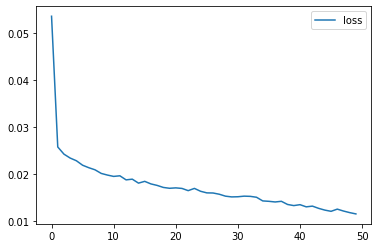

In [33]:
#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
# plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [34]:
model1.evaluate(XTrainScaled.iloc[test_index], GPAScaled.iloc[test_index], batch_size=10)

26/26 [==============================] - 0s 3ms/step - loss: 0.0264


0.02638920582830906

In [35]:
y_predict_dnn = model1.predict(XTrainScaled.iloc[test_index])
y_test = GPAScaled2.iloc[test_index]

In [36]:
mean_squared_error(y_test, y_predict_dnn)

0.026389208722473047

UNNORMALIZE TEST AND TEST PREDICT RESULTS FOR A DISPLAY

In [37]:
y_test1 = DF4.iloc[:,-1].iloc[test_index]

In [38]:
y_predict_dnn_UN = (GPAmax * y_predict_dnn) + (GPAmin * (1 - y_predict_dnn)) 
y_test_UN = (GPAmax * y_test) + (GPAmin * (1 - y_test))
y_test_UN = y_test_UN.to_numpy()

In [40]:
y_predict_dnn = y_predict_dnn.reshape(y_predict_dnn.shape[0],)
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=y_predict_dnn, name="y_predict_dnn", line_shape='linear'))
fig.update_layout(title_text='NORMALIZED DNN MODEL RESULTS', title_x=0.5)
fig.show()

In [41]:
idx   = np.argsort(y_test)
y_predict_dnn = y_predict_dnn.reshape(y_predict_dnn.shape[0],)
list1 = np.array(y_test)[idx]
list2 = np.array(y_predict_dnn)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_dnn", line_shape='linear'))
fig.update_layout(title_text='NORMALIZED DNN MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [42]:
idx   = np.argsort(y_test_UN)
y_predict_dnn_UN = y_predict_dnn_UN.reshape(y_predict_dnn_UN.shape[0],)
list1 = np.array(y_test_UN)[idx]
list2 = np.array(y_predict_dnn_UN)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test_UN", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_dnn_UN", line_shape='linear'))
fig.update_layout(title_text='UNNORMALIZED DNN MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [43]:
# MSE when Unnormalized, GPA MSE over GPA scores 0-4.0 
mean_squared_error(y_test_UN, y_predict_dnn_UN)

0.23750288132708822

In [ ]:
# #train_Input, val_Input, test_input = np.split(DF2, [int(.6 * len(DF2)), int(.8 * len(DF2))])
# DF2shuffled = shuffle(DF2)
# train_Input, test_input = np.split(DF2shuffled, [int(.8 * len(DF2))])

# X_train = train_Input.iloc[:,:-1]
# y_train = train_Input.iloc[:,-1]
# # X_val_Input = val_Input.iloc[:,:-1]
# # y_val= val_Input.iloc[:,-1]
# X_test = test_input.iloc[:,:-1]
# y_test = test_input.iloc[:,-1]

THE GAUSSIAN PROCESS REGRESSOR MODEL

In [44]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(XTrainScaled):
  #####
  # RBF: Radial-basis function kernel (aka squared-exponential kernel)
  #      Length Scale ; A vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel) 
  # WhiteKernel: Adds noise to the Kernel
  # ConstantKernel: Adding a constant kernel is equivalent to adding a constant.

  kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(length_scale = 41)  + WhiteKernel(5)

  # kernel2 = ConstantKernel(1.0) + ConstantKernel(1.0) * 1.0 * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(5)
  # The parameter nu controlling the smoothness of the learned function. 
  # The smaller nu, the less smooth the approximated function is.For nu=inf, the kernel becomes equivalent to the RBF kernel 
  # and for nu=0.5 to the absolute exponential kernel. Important intermediate values are nu=1.5 (once differentiable functions) 
  # and nu=2.5 (twice differentiable functions). Note that values of nu not in [0.5, 1.5, 2.5, inf] incur a considerably higher computational cost 
  # (appr. 10 times higher) since they require to evaluate the modified Bessel function. 
  # Furthermore, in contrast to l, nu is kept fixed to its initial value and not optimized.

  #

  # n_restarts_optimizer: The number of restarts of the optimizer for finding the kernel's parameters which maximize the log-marginal likelihood.
  model2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)
  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Fit data to model
  history2 = model2.fit(XTrainScaled.iloc[train_index], GPAScaled2.iloc[train_index])
  y_pred_tr, y_pred_tr_std = model2.predict(XTrainScaled.iloc[train_index], return_std=True)
  y_pred_te, y_pred_te_std = model2.predict(XTrainScaled.iloc[test_index], return_std=True)

  #####

  # Generate generalization metrics - model.score(X_test_Input, y_test)
  scores1 = model2.score(XTrainScaled.iloc[test_index], GPAScaled2.iloc[test_index])
  # model.score(X_test_Input, y_test)
  # # = ((y_true - y_pred)** 2).sum()  /  ((y_true - y_true.mean()) ** 2).sum()
  # # Return the coefficient of determination of the prediction.
  # # The coefficient of determination  is defined as 
  # # The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  # # A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
  
  # r2_score(y_test, y_pred_te)
  # # r2_score: R^2 (coefficient of determination) regression score function. 
  # # An R2 of 0 means your regression is no better than taking the mean value, 
  # # i.e. you are not using any information from the other variables. 
  # # A Negative R2 means you are doing worse than the mean value. :))

  #print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  scores2 = mean_squared_error(GPAScaled2.iloc[test_index], y_pred_te)

  print(f'Score for fold {fold_no}: coefficient of determination of the prediction is {scores1}')
  print(f'Score for fold {fold_no}: MSE is {scores2}')

  #acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores2)

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('MSE per fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - MSE: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 1: coefficient of determination of the prediction is 0.19628883218768833
Score for fold 1: MSE is 0.022766425547185068
------------------------------------------------------------------------
Training for fold 2 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 2: coefficient of determination of the prediction is 0.11177082169331298
Score for fold 2: MSE is 0.019849401689964734
------------------------------------------------------------------------
Training for fold 3 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 3: coefficient of determination of the prediction is 0.09838911868612987
Score for fold 3: MSE is 0.023916698546384178
------------------------------------------------------------------------
Training for fold 4 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 4: coefficient of determination of the prediction is 0.13204315245285592
Score for fold 4: MSE is 0.020656355971156667
------------------------------------------------------------------------
Training for fold 5 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 5: coefficient of determination of the prediction is 0.1312134824486324
Score for fold 5: MSE is 0.01957580946792443
------------------------------------------------------------------------
Training for fold 6 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names o

Score for fold 6: coefficient of determination of the prediction is 0.17156500351867543
Score for fold 6: MSE is 0.018172016923984347
------------------------------------------------------------------------
Training for fold 7 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 7: coefficient of determination of the prediction is 0.18078115021334418
Score for fold 7: MSE is 0.01928580195449581
------------------------------------------------------------------------
Training for fold 8 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 8: coefficient of determination of the prediction is 0.137054827097428
Score for fold 8: MSE is 0.02198224803902587
------------------------------------------------------------------------
Training for fold 9 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 9: coefficient of determination of the prediction is 0.16568470784408373
Score for fold 9: MSE is 0.01993737172787291
------------------------------------------------------------------------
Training for fold 10 ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Score for fold 10: coefficient of determination of the prediction is 0.15427005952579897
Score for fold 10: MSE is 0.017237019156992505
------------------------------------------------------------------------
MSE per fold
------------------------------------------------------------------------
> Fold 1 - MSE: 0.022766425547185068
------------------------------------------------------------------------
> Fold 2 - MSE: 0.019849401689964734
------------------------------------------------------------------------
> Fold 3 - MSE: 0.023916698546384178
------------------------------------------------------------------------
> Fold 4 - MSE: 0.020656355971156667
------------------------------------------------------------------------
> Fold 5 - MSE: 0.01957580946792443
------------------------------------------------------------------------
> Fold 6 - MSE: 0.018172016923984347
------------------------------------------------------------------------
> Fold 7 - MSE: 0.01928580195449581
----------

In [45]:
y_test = GPAScaled2.iloc[test_index]

In [46]:
y_pred_te_UN = (GPAmax * y_pred_te) + (GPAmin * (1 - y_pred_te)) 
y_test_UN = (GPAmax * y_test) + (GPAmin * (1 - y_test))
y_test_UN = y_test_UN.to_numpy()

Text(0, 0.5, 'Predicted')

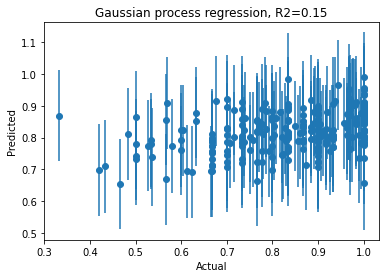

In [47]:
plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
# r2_score: R^2 (coefficient of determination) regression score function.
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [48]:
mean_squared_error(y_test, y_pred_te)

0.017237019156992505

In [49]:
idx   = np.argsort(y_test)
y_pred_te = y_pred_te.reshape(y_pred_te.shape[0],)
list1 = np.array(y_test)[idx]
list2 = np.array(y_pred_te)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_te", line_shape='linear'))
fig.update_layout(title_text='NORMALIZED - GPR MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [50]:
idx   = np.argsort(y_test_UN)
y_pred_te_UN = y_pred_te_UN.reshape(y_pred_te_UN.shape[0],)
list1 = np.array(y_test_UN)[idx]
list2 = np.array(y_pred_te_UN)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test_UN", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_pred_te_UN", line_shape='linear'))
fig.update_layout(title_text='UNNORMALIZED GPR MODEL RESULTS SORTED', title_x=0.5)
fig.show()

**CATAGORICAL APPROACH STARTS HERE**

In [30]:
#If gpa > 4 then gpa = 4;
GPACat = np.where((GPA < 4) & (GPA >= 3.75), str("A"), GPA)
GPACat = np.where((GPA < 3.75) & (GPA >= 3.50), str("B"), GPACat)
GPACat = np.where((GPA < 3.50) & (GPA >= 3.25), str("C"), GPACat)
GPACat = np.where((GPA < 3.25) & (GPA >= 3), str("D"), GPACat)
GPACat = np.where((GPA < 3) & (GPA >= 2.75), str("E"), GPACat)
GPACat = np.where((GPA < 2.75) & (GPA >= 2.5), str("F"), GPACat)
GPACat = np.where((GPA < 2.5) & (GPA >= 2.25), str("G"), GPACat)
GPACat = np.where((GPA < 2.25) & (GPA >= 2), str("H"), GPACat)
GPACat = np.where((GPA < 2) & (GPA >= 1.75), str("I"), GPACat)
GPACat = np.where((GPA < 1.75) & (GPA >= 1.5), str("J"), GPACat)
GPACat = np.where((GPA < 1.5) & (GPA >= 1.25), str("K"), GPACat)
GPACat = np.where((GPA < 1.25) & (GPA >= 1), str("L"), GPACat)
GPACat = np.where((GPA < 1) & (GPA >= 0.75), str("M"), GPACat)
GPACat = np.where((GPA < 0.75) & (GPA >= 0.50), str("N"), GPACat)
GPACat = np.where((GPA < 0.5) & (GPA >= 0.25), str("O"), GPACat)
GPACat = np.where((GPA < 0.25) & (GPA >= 0), str("P"), GPACat)

In [31]:
GPACat


array(['D', 'B', 'E', ..., 'C', 'A', 'A'], dtype='<U32')

In [ ]:
# GPACat = pd.DataFrame(GPACat)
# GPACat.astype('category')

In [32]:
labelencoder = LabelEncoder()
GPACatEnc = labelencoder.fit_transform(GPACat)

In [26]:
GPACatEnc.min()

0

In [36]:
dummy_y = np_utils.to_categorical(GPACatEnc)

In [37]:
dummy_y = pd.DataFrame(dummy_y)

In [38]:
dummy_y

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2589,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2590,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score

In [41]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(68, input_dim=68, activation='relu'))
	model.add(Dense(13, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, XTrainScaled, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


Baseline: 20.25% (3.15%)


In [35]:
# Model configuration
batch_size = 10
no_epochs = 50
verbosity = 0
num_folds = 10

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(XTrainScaled):

  # Define the model architecture
  model1 = Sequential()
  model1.add(Dense(68, input_dim=68, kernel_initializer='normal', activation='relu'))
  model1.add(Dense(13, activation='softmax'))
  # Compile model
  model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model1.fit(XTrainScaled.iloc[train_index], dummy_y.iloc[train_index],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model1.evaluate(XTrainScaled.iloc[test_index], dummy_y.iloc[test_index], verbose=0)
  #print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  
  print(f'Score for fold {fold_no}: {model1.metrics_names[1]} is {scores[1]}')

  acc_per_fold.append(scores[1] * 100)
  #loss_per_fold.append(scores)

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: accuracy is 0.23076923191547394
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: accuracy is 0.2230769246816635
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: accuracy is 0.2509652376174927
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: accuracy is 0.1814671754837036
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: accuracy is 0.21235521137714386
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: accuracy is 0.2702702581882477
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: accurac

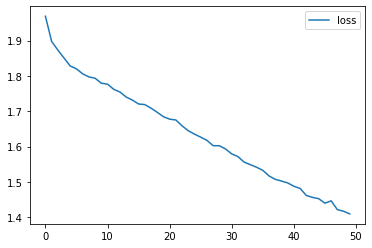

In [36]:
#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
# plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [ ]:
model1.evaluate(XTrainScaled.iloc[test_index], GPAScaled.iloc[test_index], batch_size=10)

26/26 [==============================] - 0s 3ms/step - loss: 0.0264


0.02638920582830906

In [ ]:
y_predict_dnn = model1.predict(XTrainScaled.iloc[test_index])
y_test = GPAScaled2.iloc[test_index]

In [ ]:
mean_squared_error(y_test, y_predict_dnn)

0.026389208722473047

In [ ]:
y_test1 = DF4.iloc[:,-1].iloc[test_index]

In [ ]:
y_predict_dnn_UN = (GPAmax * y_predict_dnn) + (GPAmin * (1 - y_predict_dnn)) 
y_test_UN = (GPAmax * y_test) + (GPAmin * (1 - y_test))
y_test_UN = y_test_UN.to_numpy()

In [ ]:
y_predict_dnn = y_predict_dnn.reshape(y_predict_dnn.shape[0],)
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=y_predict_dnn, name="y_predict_dnn", line_shape='linear'))
fig.update_layout(title_text='NORMALIZED DNN MODEL RESULTS', title_x=0.5)
fig.show()

In [ ]:
idx   = np.argsort(y_test)
y_predict_dnn = y_predict_dnn.reshape(y_predict_dnn.shape[0],)
list1 = np.array(y_test)[idx]
list2 = np.array(y_predict_dnn)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_dnn", line_shape='linear'))
fig.update_layout(title_text='NORMALIZED DNN MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [ ]:
idx   = np.argsort(y_test_UN)
y_predict_dnn_UN = y_predict_dnn_UN.reshape(y_predict_dnn_UN.shape[0],)
list1 = np.array(y_test_UN)[idx]
list2 = np.array(y_predict_dnn_UN)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test_UN", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_dnn_UN", line_shape='linear'))
fig.update_layout(title_text='UNNORMALIZED DNN MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [ ]:
# MSE when Unnormalized, GPA MSE over GPA scores 0-4.0 
mean_squared_error(y_test_UN, y_predict_dnn_UN)

0.23750288132708822

**KNN STARTS HERE**

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics

In [33]:
kmeans1 = KMeans(n_clusters = 13, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans1 = kmeans1.fit_predict(XTrainScaled)
score = silhouette_score(XTrainScaled, kmeans1.labels_, metric='euclidean')
# Print the score
print('Silhouette Score: %.3f' % score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Silhouette Score: 0.032


In [34]:
from sklearn.decomposition import PCA

In [35]:
for i in range(68):
  pca = PCA(n_components=i)
  principalcomponents = pca.fit_transform(XTrainScaled)
  var = sum(pca.explained_variance_ratio_)
  if var >= 0.95:
    break
print(f'Number of component for %95 variance:', i)
print(f'The variance is:', var)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Number of component for %95 variance: 44
The variance is: 0.9514031845242517


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
